# **Inference in the linear regression model**

We will analyse asymptotic inference when we do not assume normality of the errors.
Considering the model y=α+βx+ μ, where x is a scalar, α=3, β=1 and x ~ N(2,1) we will analyse how statistical inference changes if we do not assume error normality. For comparison we will use the following benchmark: μ ~ N(0,12).

First, we will generate 2000 samples of 10 observations each and, for each sample, we will estimate by classical least squares the parameters of the model and test the null hypothesis that β=1 versus the alternative hypothesis that β≠1. For hypothesis testing we will use a t-test and a significance level of 5%. Finally, we will report the test size, which is nothing more than the proportion of the 2000 samples in which the null hypothesis is rejected.

Then, this process will be replicated by generating 2000 samples of 20, 100, 200, 500, 1000, 5000 and 10000 observations each.

## Paquetes

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, chi2
from scipy.stats import t as t_distribution
from scipy.optimize import minimize

## Parameters

In [4]:
# Seed
np.random.seed(4678)

# Parameters
alpha = 3
beta_true = 1
sigma_true = 12  # Variance of errors in the benchmark

# Sample_size
tamanos_muestra = [10, 20, 100, 200, 500, 1000, 5000, 10000]

# Distributions
distribuciones = ["Uniforme", "Beta", "Bernoulli", "t-Student", "Benchmark", "Benchmark_outlier"]

## Functions

In [5]:
# Function to generate samples according to specified distribution
def generar_muestras(n, distribucion):
    if distribucion == "Uniforme":
        u = np.random.uniform(low=-6, high=6, size=n) # Generates samples of Uniform distribution
    elif distribucion == "Beta":
        beta_sample = np.random.beta(2, 5, size=n) # Generates samples of Beta distribution
        u = 12 * (beta_sample - 2/7)
    elif distribucion == "Bernoulli":
        u = (bernoulli.rvs(0.8, size=n) - 0.8) * np.sqrt(75) # Generates samples of Bernoulli distribution
    elif distribucion == "t-Student":
        u = np.random.standard_t(2.1818, size=n) # Generates samples of t-Student distribution
    elif distribucion == "Benchmark":
        u = np.random.normal(0, np.sqrt(12), size=n) # Generates samples of Normal distribution
    elif distribucion == "Benchmark_outlier":
        u = np.random.normal(0, np.sqrt(12), size=n) # Generates samples of Normal distribution
        u[0] = 500 # We add an outlier in the first observation
    else:
        raise ValueError("Distribución no reconocida") # Treatment of errors in expressions

    # We generate samples from a normal distribution with mean 2 and variance 1.
    x = np.random.normal(2, 1, size=n)
    # We generate values of y using a linear model
    y = alpha + beta_true * x + u

    return x, y

# Function to estimate the model
def ajustar_modelo(x, y):
    X = np.column_stack((np.ones_like(x), x)) # Construimos una matriz X
    res = minimize(lambda beta: np.sum((y - np.dot(X, beta))**2), x0=[0, 0], method='L-BFGS-B') # Estimamos por MCC
    beta_hat = res.x # We obtain the estimated coefficients
    y_pred = np.dot(X, beta_hat) # Model predictions
    residuals = y - y_pred # Model residuals
    s_squared = np.sum(residuals**2) / (len(x) - 2) # Variance estimation
    var_beta = s_squared * np.linalg.inv(np.dot(X.T, X))[1, 1] # Coefficients variance
    return beta_hat[1], var_beta

# Function to perform t-test
def test_t(x, y):
    beta_hat, var_beta = ajustar_modelo(x, y)
    beta_0 = 1 # Null value for the t-test
    t_statistic = (beta_hat - beta_0) / np.sqrt(var_beta) # Statistic t
    p_value = 2 * (1 - t_distribution.cdf(np.abs(t_statistic), df=len(x) - 2)) # P value
    significativo = p_value < 0.05 # Significance
    return p_value, significativo

## Simulations

In [6]:
# Simulations
resultados = {}
resultados_coeficientes = {}
errores_estimacion = {distribucion: [] for distribucion in distribuciones}

# We go through each of the distributions
for distribucion in distribuciones:
    resultados[distribucion] = []
    resultados_coeficientes[distribucion] = []

    # We go through each of the sample sizes
    for n in tamanos_muestra:
        rechazos = 0
        coeficientes_estimados = []
        errores = []

        # For each of the 2000 samples of sample size n
        for _ in range(2000):
            x, y = generar_muestras(n, distribucion)
            _, significativo = test_t(x, y)
            rechazos += significativo
            coef_estimados = ajustar_modelo(x, y)
            beta_estimado = coef_estimados[0]
            error_estimacion = beta_estimado - beta_true
            coeficientes_estimados.append(coef_estimados)
            errores.append(error_estimacion)

        tamaño_test = rechazos / 2000
        resultados[distribucion].append(tamaño_test)
        resultados_coeficientes[distribucion].append(np.mean(coeficientes_estimados, axis=0))
        errores_estimacion[distribucion].append(np.mean(errores))

## Results



### Test Size

In [14]:
# We print results in tabular form rounded to 3 decimal places.
print("{:<14} {:<14} {:<14} {:<14} {:<14} {:<14} {:<14}".format(
    "n", "Uniforme", "Beta", "Bernoulli", "t-Student", "Benchmark", "Benchmark_outlier"
))

for i, n in enumerate(tamanos_muestra):
    print("{:<15}".format(n), end="")
    for distribucion in distribuciones:
        tamaño_test = resultados[distribucion][i]
        print("{:<15.3f}".format(tamaño_test), end="")
    print()

# Create a DataFrame with the results
df_resultados = pd.DataFrame(resultados, index=tamanos_muestra)
df_resultados = df_resultados.round(3)

# Exporting the DataFrame to an Excel file
excel_filename = 'test_size.xlsx'
df_resultados.to_excel(excel_filename)

print(f"Results exported to {excel_filename}")

n              Uniforme       Beta           Bernoulli      t-Student      Benchmark      Benchmark_outlier
10             0.053          0.062          0.132          0.057          0.058          0.058          
20             0.045          0.045          0.054          0.045          0.050          0.049          
100            0.058          0.053          0.045          0.045          0.045          0.053          
200            0.046          0.046          0.048          0.049          0.050          0.044          
500            0.050          0.043          0.057          0.049          0.044          0.053          
1000           0.050          0.057          0.043          0.053          0.051          0.045          
5000           0.051          0.051          0.048          0.053          0.045          0.049          
10000          0.052          0.043          0.045          0.056          0.045          0.051          
Results exported to test_size.xlsx


### Comparison of distributions vs Benchmark

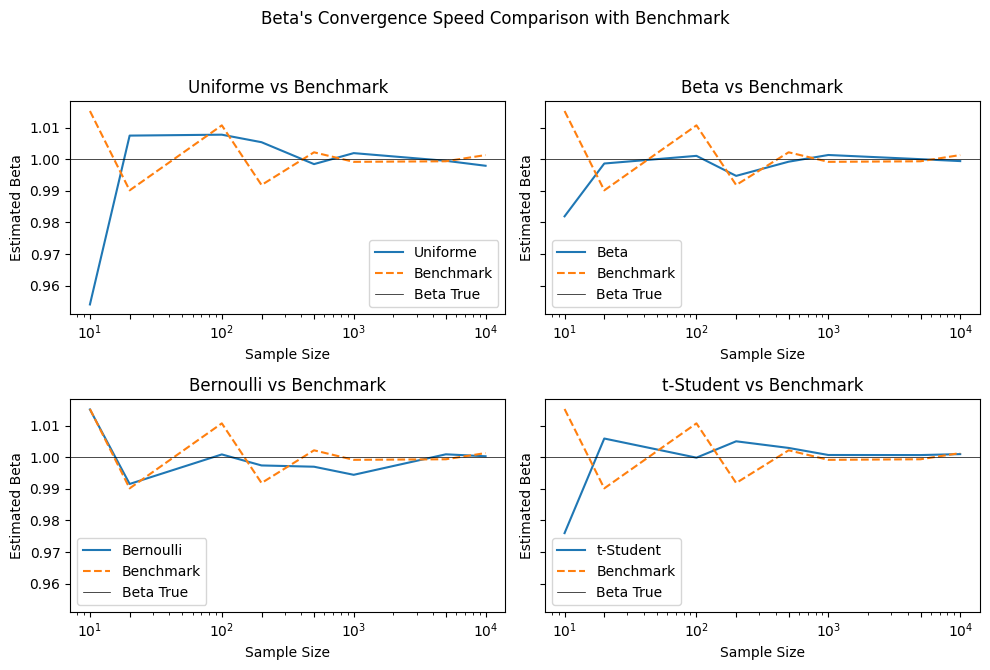

In [8]:
# Comparison of distributions vs Benchmark
fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharex=False, sharey=True)
fig.suptitle("Beta's Convergence Speed Comparison with Benchmark")

for i, benchmark_distribucion in enumerate(distribuciones[:-2]):
    ax = axs[i // 2, i % 2]
    ax.plot(tamanos_muestra, [result[0] for result in resultados_coeficientes[benchmark_distribucion]], label=f'{benchmark_distribucion}')
    ax.plot(tamanos_muestra, [result[0] for result in resultados_coeficientes["Benchmark"]], label="Benchmark", linestyle='--')
    ax.set_xscale('log')
    ax.set_xticks(tamanos_muestra)
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Estimated Beta')
    ax.set_title(f'{benchmark_distribucion} vs Benchmark')
    ax.axhline(y=1, color='black', label='Beta True', linewidth=0.5)
    ax.legend()

# Adjust the design of the subcharts
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

### Comparison of distributions vs Benchmark_Outlier

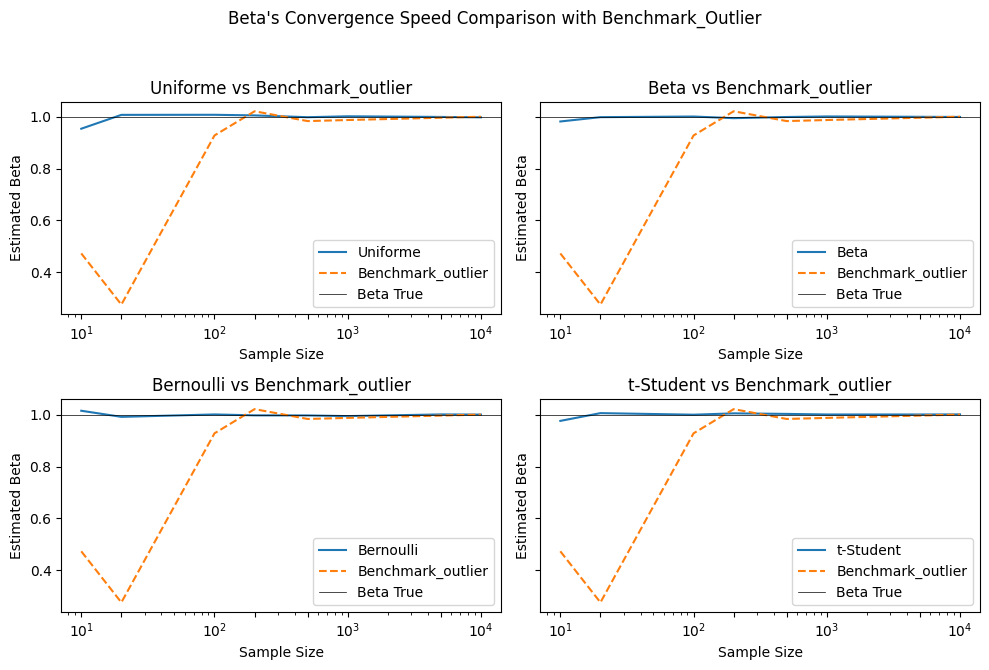

In [9]:
# Comparison of distributions vs Benchmark_Outlier
fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharex=False, sharey=True)
fig.suptitle("Beta's Convergence Speed Comparison with Benchmark_Outlier")

for i, benchmark_distribucion in enumerate(distribuciones[:-2]):
    ax = axs[i // 2, i % 2]
    ax.plot(tamanos_muestra, [result[0] for result in resultados_coeficientes[benchmark_distribucion]], label=f'{benchmark_distribucion}')
    ax.plot(tamanos_muestra, [result[0] for result in resultados_coeficientes["Benchmark_outlier"]], label="Benchmark_outlier", linestyle='--')
    ax.set_xscale('log')
    ax.set_xticks(tamanos_muestra)
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Estimated Beta')
    ax.set_title(f'{benchmark_distribucion} vs Benchmark_outlier')
    ax.axhline(y=1, color='black', label='Beta True', linewidth=0.5)
    ax.legend()

# Adjust the design of the subcharts
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

### Convergence Speed of the Betas

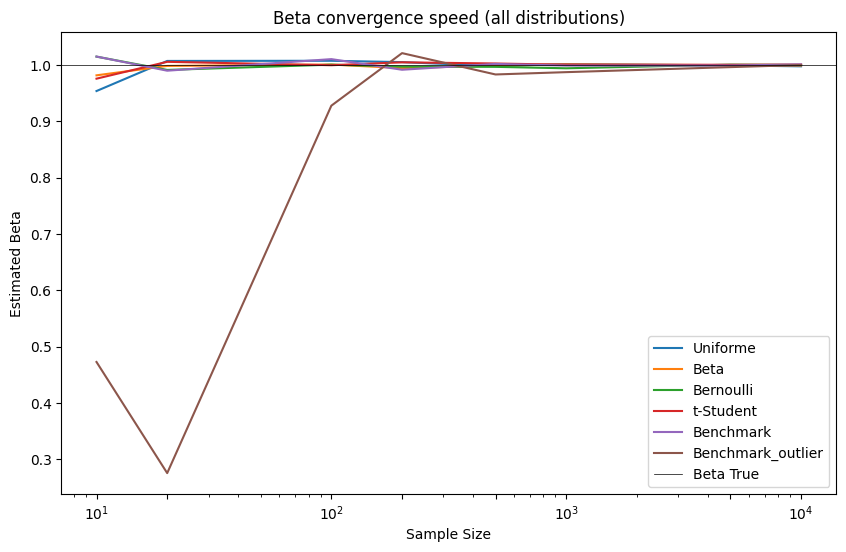

In [10]:
# Beta convergence speed (all distributions)
plt.figure(figsize=(10, 6))
for distribucion in distribuciones:
    plt.plot(tamanos_muestra, [result[0] for result in resultados_coeficientes[distribucion]], label=distribucion)
plt.xscale('log')
plt.xticks(tamanos_muestra)
plt.axhline(y=1, color='black', label='Beta True', linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Estimated Beta')
plt.title('Beta convergence speed (all distributions)')
plt.legend()
plt.show()

### Convergence speed of Betas without Outlier

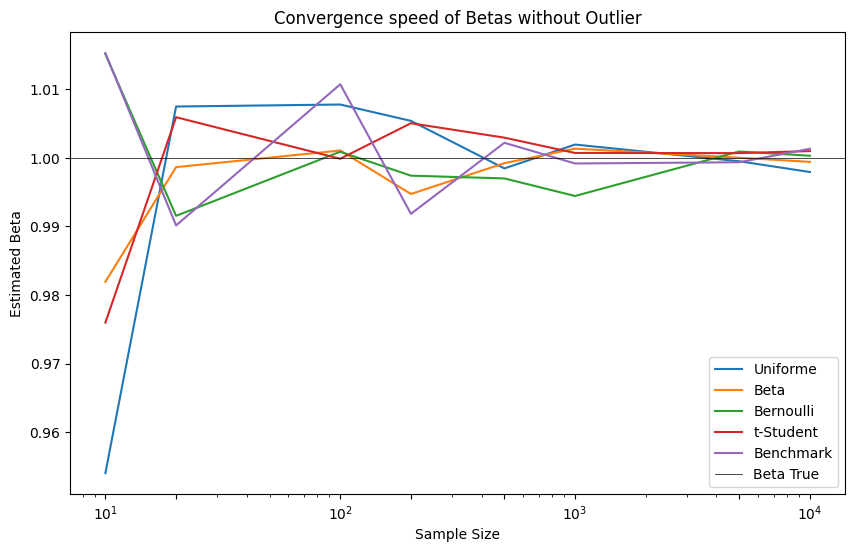

In [11]:
# Convergence speed of Betas without Outlier
plt.figure(figsize=(10, 6))
for distribucion in distribuciones[:-1]:
    plt.plot(tamanos_muestra, [result[0] for result in resultados_coeficientes[distribucion]], label=distribucion)
plt.xscale('log')
plt.axhline(y=1, color='black', label='Beta True', linewidth=0.5)
plt.xticks(tamanos_muestra)
plt.xlabel('Sample Size')
plt.ylabel('Estimated Beta')
plt.title('Convergence speed of Betas without Outlier')
plt.legend()
plt.show()

### Estimation errors

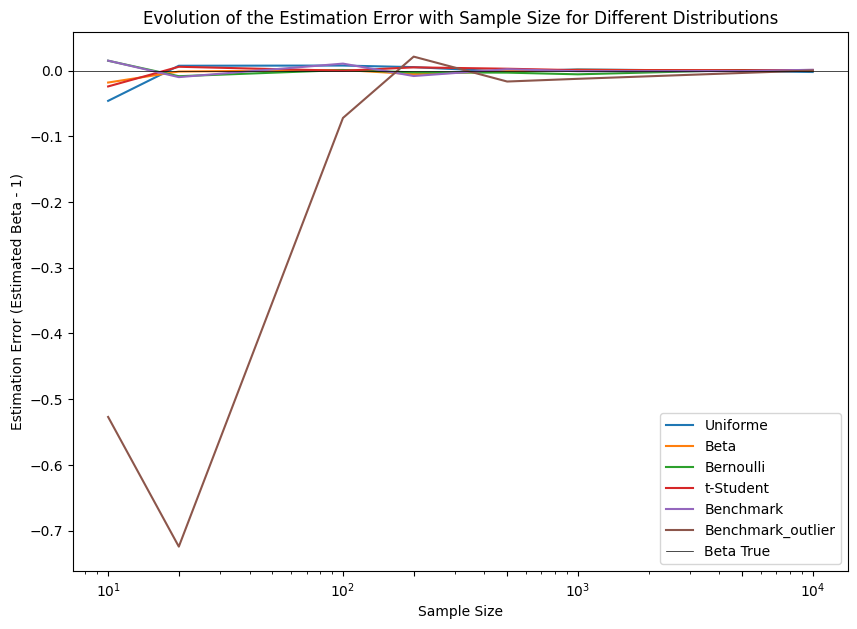

In [12]:
# Estimation errors for each distribution
plt.figure(figsize=(10, 7))
for distribucion in distribuciones:
    plt.plot(tamanos_muestra, errores_estimacion[distribucion], label=distribucion)
plt.xscale('log')
plt.xlabel('Sample Size')
plt.xticks(tamanos_muestra)
plt.axhline(y=0, color='black', label='Beta True', linewidth=0.5)
plt.ylabel(f'Estimation Error (Estimated Beta - {beta_true})')
plt.title('Evolution of the Estimation Error with Sample Size for Different Distributions')
plt.legend()
plt.show()

### Estimation errors without Benchmark_Outlier



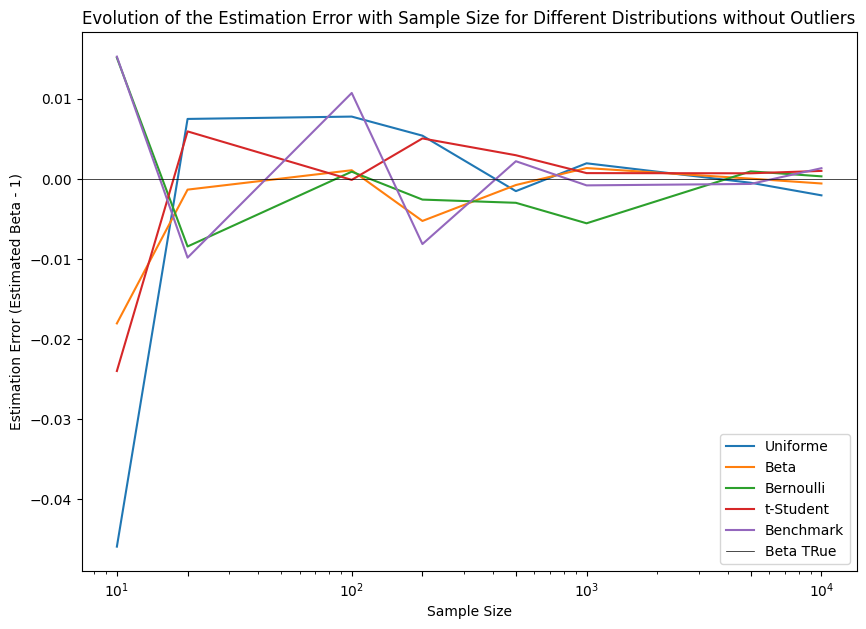

In [13]:
# Estimation errors for each distribution without Benchmark_Outlier
plt.figure(figsize=(10, 7))
for distribucion in distribuciones[:-1]:
    plt.plot(tamanos_muestra, errores_estimacion[distribucion], label=distribucion)
plt.xscale('log')
plt.xlabel('Sample Size')
plt.xticks(tamanos_muestra)
plt.axhline(y=0, color='black', label='Beta TRue', linewidth=0.5)
plt.ylabel(f'Estimation Error (Estimated Beta - {beta_true})')
plt.title('Evolution of the Estimation Error with Sample Size for Different Distributions without Outliers')
plt.legend()
plt.show()